In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from scipy import stats
import statsmodels.api as sm

In [57]:
# Load crime data
df = pd.read_csv('data\crime_data.csv')

# Drop irrelevant columns (all NaN or unnecessary)
df = df.drop(columns=['TIME', 'Count_'], errors='ignore')

In [58]:
# Inspect data: Checking types, missing values, etc.
print(df.head()) # First 5 rows
print(df.info()) # Data types, non-null counts
print(df.describe()) # Stats for numerics
print(df.isnull().sum()) # Stats for nulls per column

   CASE_NUMBER                    DATE  CODE  \
0     14174782  2014/08/17 23:00:00+00   510   
1     14174803  2014/08/18 03:24:00+00  1400   
2     14174804  2014/08/18 03:24:00+00   691   
3     14174813  2014/08/18 03:37:00+00   600   
4     14174817  2014/08/18 03:41:00+00   700   

                              INCIDENT_TYPE    INCIDENT  POLICE_GRID_NUMBER  \
0  Burglary, Forced Entry, Night, Residence    Burglary               115.0   
1               Criminal Damage to Property   Vandalism               128.0   
2              Theft, All Other, Under $500       Theft               107.0   
3                  Theft, Except Auto Theft       Theft               193.0   
4                       Motor Vehicle Theft  Auto Theft               132.0   

   NEIGHBORHOOD_NUMBER      NEIGHBORHOOD_NAME                BLOCK  \
0                    4     4 - Dayton's Bluff       101X EUCLID ST   
1                    8  8 - Summit/University        64X DAYTON AV   
2                    8  8 

In [59]:
# Handle any missing data
df = df.dropna(subset=['DATE', 'INCIDENT_TYPE', 'NEIGHBORHOOD_NUMBER']) # Drop if key columns missing
df = df[df['INCIDENT'] != "0"]

# Handle missing INCIDENTS by copying from INCIDENT_TYPE
df['INCIDENT'] = df.apply(lambda row: row['INCIDENT_TYPE'] if pd.isna(row['INCIDENT']) else row['INCIDENT'], axis=1)

# Handle POLICE_GRID_NUMBER
df['POLICE_GRID_NUMBER'] = df['POLICE_GRID_NUMBER'].fillna(-1).astype(int)

# Handle BLOCK
df['BLOCK'] = df['BLOCK'].fillna('Unknown')

In [60]:
# Parse dates/times to help with time-based analysis

df['DATETIME'] = pd.to_datetime(df['DATE'], utc=True).dt.tz_convert('America/Chicago')
df['YEAR'] = df['DATETIME'].dt.year
df['MONTH'] = df['DATETIME'].dt.month
df['HOUR'] = df['DATETIME'].dt.hour
df['DAY_OF_WEEK'] = df['DATETIME'].dt.day_name().astype('string')
df['SEASON'] = df['MONTH'].apply(lambda m: 'Winter' if m in [12,1,2] else 
                                 'Spring' if m in [3,4,5] else 
                                 'Summer' if m in [6,7,8] else 'Fall')

In [61]:
# Standardize neighborhood names (removing numbers from names)
df['NEIGHBORHOOD_NAME'] = df['NEIGHBORHOOD_NAME'].str.replace(r'^\d+ - ', '', regex=True).str.strip()

# Standardize categories to fix inconsistencies
df['INCIDENT'] = df['INCIDENT'].str.title().str.strip()

# Create mapping for incident type inconcsistencies
incident_map = {
    'Agg. Assault Dom': 'Agg. Assault Dom.',
    'Community Event': 'Community Engagement Event',
    'Graffiti (Felony Over $1000)': 'Graffiti',
    'Graffiti (Gm $501 To $1000)': 'Graffiti',
    'Simple Assault Dom': 'Simple Assault Dom.',
    'Simple Asasult Dom.': 'Simple Assault Dom.',
}

# Apply it (lower + strip first for matching)
df['INCIDENT_CLEAN'] = df['INCIDENT'].replace(incident_map)

# Filter out proactive visits for actual crimes
df_no_proactive = df[df['INCIDENT_CLEAN'] != 'Proactive Police Visit']

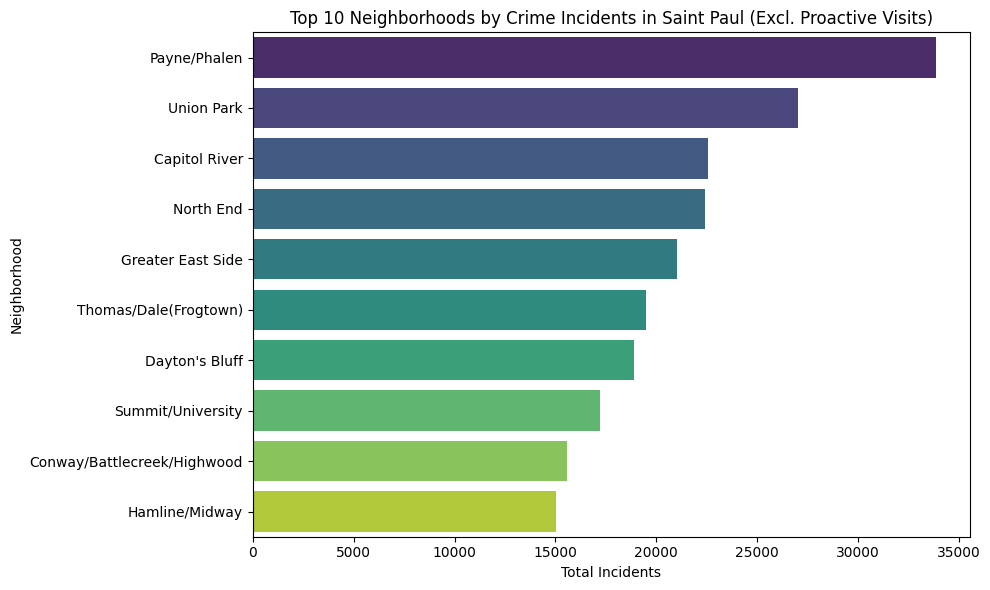

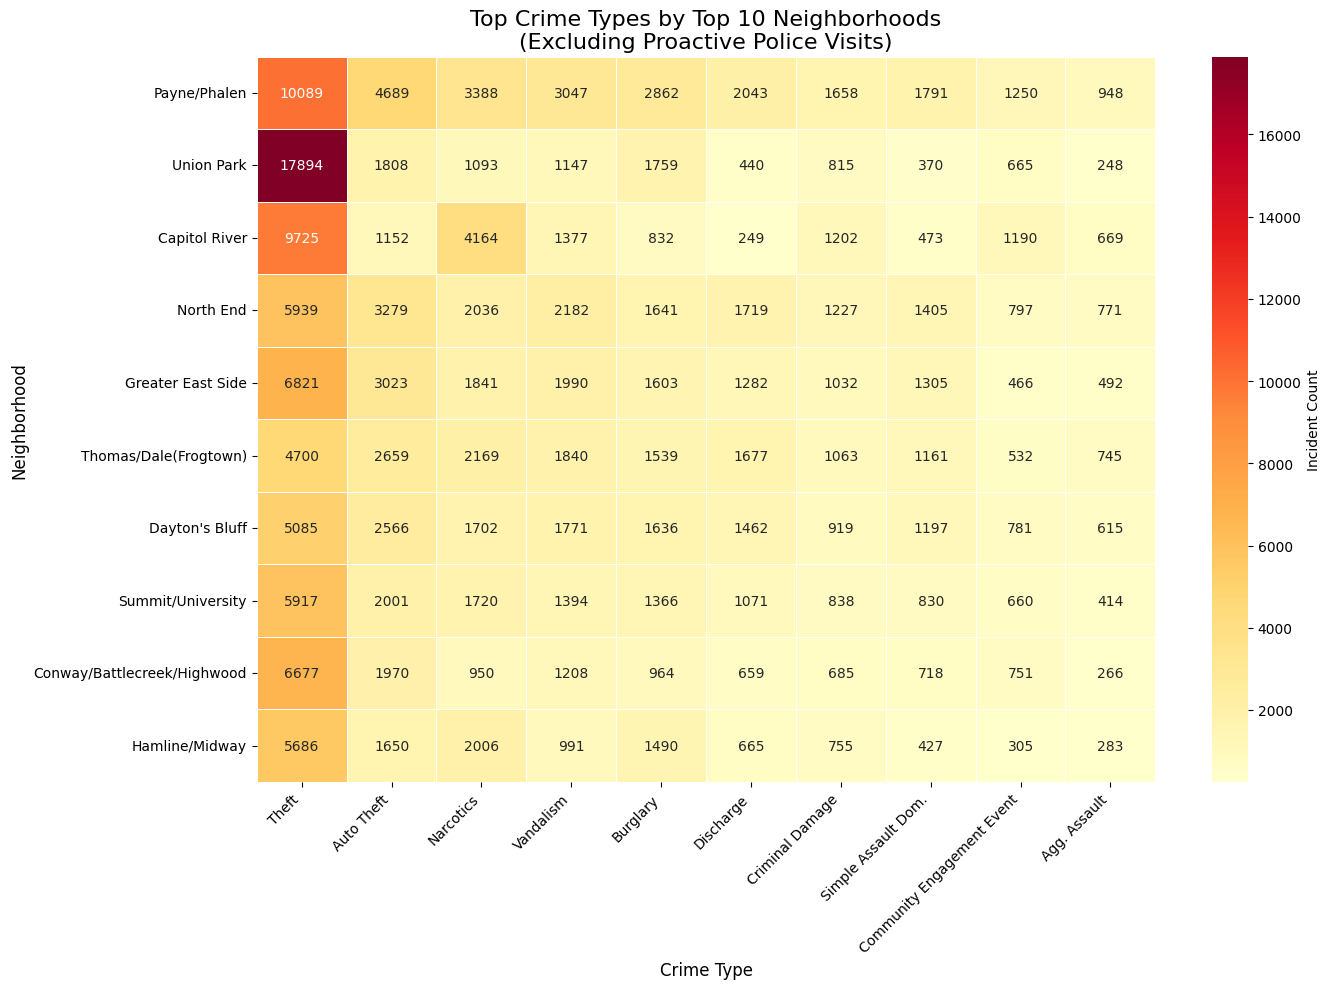

In [62]:
# Top 10 Neighborhoods by Total Crimes (excluding proactive)
neighborhood_counts = df_no_proactive['NEIGHBORHOOD_NAME'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=neighborhood_counts.values, y=neighborhood_counts.index, palette="viridis")
plt.title('Top 10 Neighborhoods by Crime Incidents in Saint Paul (Excl. Proactive Visits)')
plt.xlabel('Total Incidents')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.savefig('neighborhood_crimes.png', dpi=300)
plt.show()

# Heatmap of top crime types per top neighborhoods
pivot_no_pro = df_no_proactive.pivot_table(index='NEIGHBORHOOD_NAME', columns='INCIDENT_CLEAN', aggfunc='size', fill_value=0)
top_10_neigh = pivot_no_pro.sum(axis=1).nlargest(10).index
top_neigh_filtered = pivot_no_pro.loc[top_10_neigh]
top_crime_types = top_neigh_filtered.sum().nlargest(10).index
top_neigh_filtered = top_neigh_filtered[top_crime_types]

plt.figure(figsize=(14, 10))
sns.heatmap(top_neigh_filtered, cmap='YlOrRd', annot=True, fmt='d', linewidths=0.5, cbar_kws={'label': 'Incident Count'})
plt.title('Top Crime Types by Top 10 Neighborhoods\n(Excluding Proactive Police Visits)', fontsize=16)
plt.xlabel('Crime Type', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('neighborhood_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [63]:
# Save cleaned data for reproducibility
df_no_proactive.to_csv('data\cleaned_crime_data.csv', index=False)